<a href="https://colab.research.google.com/github/usmanhanafi/Machine-Learning-Cohort-Bangkit-2024/blob/main/dead_chicken_transfer_learning_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras pandas matplotlib opencv-python

In [ ]:
import os
import gdown
import zipfile
import pandas as pd
from shutil import copyfile
import random
from tqdm import tqdm  # Progress bar
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from google.colab import files
from tensorflow.keras.preprocessing import image
import io
from tensorflow.keras.models import load_model

In [ ]:
url = 'https://drive.google.com/file/d/1hBr1oaQJ0XxII83tL5HSCrFVY0SkH9xV/view?usp=sharing'

In [ ]:
file_id = url.split('/d/')[1].split('/')[0]
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

zip_path = '/content/dataset_ayam.zip'
extract_path = '/content/dataset'

try:
    if not os.path.exists(zip_path):
        gdown.download(download_url, zip_path, quiet=False)
    else:
        print(f"{zip_path} already exists, skipping download.")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("Dataset berhasil diekstrak!")
except Exception as e:
    print(f"An error occurred: {e}")


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1hBr1oaQJ0XxII83tL5HSCrFVY0SkH9xV
From (redirected): https://drive.google.com/uc?export=download&id=1hBr1oaQJ0XxII83tL5HSCrFVY0SkH9xV&confirm=t&uuid=5ed830ef-6928-4b7e-91f2-5f923cad23e5
To: /content/dataset_ayam.zip
100%|██████████| 611M/611M [00:06<00:00, 95.2MB/s]


Dataset berhasil diekstrak!


In [ ]:

dead_folder_paths = [
    '/content/dataset/train',
    '/content/dataset/test',
    '/content/dataset/valid'
]

dead_image_counts = {}
for folder_path in dead_folder_paths:
    if os.path.exists(folder_path):
        dead_image_counts[folder_path] = len(os.listdir(folder_path))

dead_image_counts

{'/content/dataset/train': 6293,
 '/content/dataset/test': 197,
 '/content/dataset/valid': 593}

In [ ]:
base_dir = '/content/dataset'
folders = ['train', 'test', 'valid']
target_folder = '/content/preprocess_datasets'

for folder in folders:
    os.makedirs(os.path.join(target_folder, folder, 'dead'), exist_ok=True)
    os.makedirs(os.path.join(target_folder, folder, 'alive'), exist_ok=True)

def process_annotations(base_path, folder_name, target_path):
    csv_path = os.path.join(base_path, folder_name, '_annotations.csv')
    images_path = os.path.join(base_path, folder_name)

    target_dead_path = os.path.join(target_path, folder_name, 'dead')
    target_alive_path = os.path.join(target_path, folder_name, 'alive')

    if os.path.exists(csv_path):
        print(f"Memproses folder: {folder_name}")
        annotations = pd.read_csv(csv_path)
        print(f"Isi anotasi di {csv_path}:")
        print(annotations.head())

        dead_images = annotations[annotations['class'] == 'Sick']['filename'].unique()
        alive_images = annotations[annotations['class'] == 'Healthy']['filename'].unique()

        min_class_size = min(len(dead_images), len(alive_images))

        if len(dead_images) > min_class_size:
            dead_images = random.sample(list(dead_images), min_class_size)
            print(f"Undersampling: Mengambil {len(dead_images)} gambar dari kelas 'dead'.")

        if len(alive_images) > min_class_size:
            alive_images = random.sample(list(alive_images), min_class_size)
            print(f"Undersampling: Mengambil {len(alive_images)} gambar dari kelas 'alive'.")

        for image_name in tqdm(dead_images, desc=f"Copying dead images ({folder_name})"):
            source = os.path.join(images_path, image_name)
            destination = os.path.join(target_dead_path, image_name)
            if os.path.exists(source):
                copyfile(source, destination)
            else:
                print(f"File tidak ditemukan: {source}")

        for image_name in tqdm(alive_images, desc=f"Copying alive images ({folder_name})"):
            source = os.path.join(images_path, image_name)
            destination = os.path.join(target_alive_path, image_name)
            if os.path.exists(source):
                copyfile(source, destination)
            else:
                print(f"File tidak ditemukan: {source}")
    else:
        print(f"File anotasi tidak ditemukan: {csv_path}")

for folder in folders:
    process_annotations(base_dir, folder, target_folder)

print("\nValidasi jumlah file di folder target:")
for subset in folders:
    for class_name in ['dead', 'alive']:
        folder_path = os.path.join(target_folder, subset, class_name)
        num_files = len(os.listdir(folder_path))
        print(f"Jumlah gambar di {folder_path}: {num_files}")

print("\nProses pemisahan dan penyeimbangan dataset selesai.")



Memproses folder: train
Isi anotasi di /content/dataset/train/_annotations.csv:
                                            filename  width  height    class  \
0  IMG_20220513_174053_HHT_jpg.rf.0031754093e51d0...    640     640     Sick   
1  IMG_20220513_170651_HHT_jpg.rf.00348d0a31d3de0...    640     640  Healthy   
2  IMG_20220513_172912_HHT_jpg.rf.0061fdcff479791...    640     640     Sick   
3  IMG_20220513_172124_HHT_jpg.rf.0043e16b5b5c22f...    640     640  Healthy   
4  IMG_20220513_171129_HHT_jpg.rf.0026f0da9166799...    640     640  Healthy   

   xmin  ymin  xmax  ymax  
0   180   235   399   346  
1   237   199   436   390  
2   227   242   451   417  
3   252   281   439   401  
4   214   253   427   403  
Undersampling: Mengambil 2656 gambar dari kelas 'alive'.


Copying alive images (train): 100%|██████████| 2656/2656 [00:00<00:00, 6242.90it/s]


Memproses folder: test
Isi anotasi di /content/dataset/test/_annotations.csv:
                                            filename  width  height    class  \
0  IMG_20220513_172026_HHT_jpg.rf.0beab51c5a06f10...    640     640  Healthy   
1  IMG_5820_PNG_jpg.rf.17b5d517cd22f3d1bd1f740402...    640     640  Healthy   
2  IMG_5820_PNG_jpg.rf.17b5d517cd22f3d1bd1f740402...    640     640  Healthy   
3  IMG_5820_PNG_jpg.rf.17b5d517cd22f3d1bd1f740402...    640     640  Healthy   
4  IMG_5820_PNG_jpg.rf.17b5d517cd22f3d1bd1f740402...    640     640  Healthy   

   xmin  ymin  xmax  ymax  
0   191   297   482   423  
1   244    12   303   222  
2   388   173   439   364  
3   448   190   526   378  
4   116   232   212   417  
Undersampling: Mengambil 90 gambar dari kelas 'alive'.


Copying alive images (test): 100%|██████████| 90/90 [00:00<00:00, 5750.79it/s]


Memproses folder: valid
Isi anotasi di /content/dataset/valid/_annotations.csv:
                                            filename  width  height    class  \
0  IMG_20220513_171740_HHT_jpg.rf.017a5cd7f0f2bf5...    640     640  Healthy   
1  IMG_20220513_173409_HHT_jpg.rf.000a52b3a153bd7...    640     640     Sick   
2  IMG20220702135346_jpg.rf.022bfdf505fd891da6f6d...    640     640  Healthy   
3  images-1-_jpg.rf.003181da4a752775d1108b4e4294b...    640     640  Healthy   
4  images-1-_jpg.rf.003181da4a752775d1108b4e4294b...    640     640  Healthy   

   xmin  ymin  xmax  ymax  
0   253   267   446   400  
1   209   265   422   445  
2   227   188   561   639  
3   230   462   376   599  
4   134   216   220   417  
Undersampling: Mengambil 244 gambar dari kelas 'alive'.


Copying alive images (valid): 100%|██████████| 244/244 [00:00<00:00, 6148.08it/s]


Validasi jumlah file di folder target:
Jumlah gambar di /content/preprocess_datasets/train/dead: 2656
Jumlah gambar di /content/preprocess_datasets/train/alive: 2656
Jumlah gambar di /content/preprocess_datasets/test/dead: 90
Jumlah gambar di /content/preprocess_datasets/test/alive: 90
Jumlah gambar di /content/preprocess_datasets/valid/dead: 244
Jumlah gambar di /content/preprocess_datasets/valid/alive: 244

Proses pemisahan dan penyeimbangan dataset selesai.


In [ ]:
target_folder = '/content/preprocess_datasets'

for subset in ['train', 'valid']:
    for class_name in ['dead', 'alive']:
        folder_path = os.path.join(target_folder, subset, class_name)
        num_files = len(os.listdir(folder_path))
        print(f"Jumlah gambar di {folder_path}: {num_files}")


Jumlah gambar di /content/preprocess_datasets/train/dead: 2656
Jumlah gambar di /content/preprocess_datasets/train/alive: 2656
Jumlah gambar di /content/preprocess_datasets/valid/dead: 244
Jumlah gambar di /content/preprocess_datasets/valid/alive: 244


In [ ]:
train_dir = '/content/preprocess_datasets/train'
valid_dir = '/content/preprocess_datasets/valid'
test_dir = '/content/preprocess_datasets/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# valid_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5312 images belonging to 2 classes.
Found 488 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max',  # Memonitor nilai maksimum dari 'val_accuracy'
    verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
166/166 [==============================] - 330s 2s/step - loss: 0.3329 - accuracy: 0.8556 - auc_1: 0.9319 - val_loss: 0.2016 - val_accuracy: 0.9221 - val_auc_1: 0.9767
Epoch 2/10
166/166 [==============================] - 323s 2s/step - loss: 0.2278 - accuracy: 0.9087 - auc_1: 0.9678 - val_loss: 0.1755 - val_accuracy: 0.9344 - val_auc_1: 0.9867
Epoch 3/10
166/166 [==============================] - 322s 2s/step - loss: 0.1945 - accuracy: 0.9219 - auc_1: 0.9765 - val_loss: 0.1598 - val_accuracy: 0.9385 - val_auc_1: 0.9874
Epoch 4/10
166/166 [==============================] - 322s 2s/step - loss: 0.1754 - accuracy: 0.9287 - auc_1: 0.9810 - val_loss: 0.1219 - val_accuracy: 0.9406 - val_auc_1: 0.9912
Epoch 5/10
166/166 [==============================] - 319s 2s/step - loss: 0.1695 - accuracy: 0.9302 - auc_1: 0.9822 - val_loss: 0.1150 - val_accuracy: 0.9570 - val_auc_1: 0.9932
Epoch 6/10
166/166 [==============================] - 320s 2s/step - loss: 0.1571 - accuracy: 0.9388 - au

In [ ]:
base_model.trainable = True
fine_tune_at = 100  # fine-tuning setelah lapisan ke-100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC()])


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
166/166 [==============================] - 480s 3s/step - loss: 0.2525 - accuracy: 0.8933 - auc_2: 0.9648 - val_loss: 0.1210 - val_accuracy: 0.9529 - val_auc_2: 0.9901
Epoch 2/10
166/166 [==============================] - 457s 3s/step - loss: 0.1861 - accuracy: 0.9283 - auc_2: 0.9788 - val_loss: 0.0867 - val_accuracy: 0.9693 - val_auc_2: 0.9943
Epoch 3/10
166/166 [==============================] - 460s 3s/step - loss: 0.1497 - accuracy: 0.9418 - auc_2: 0.9861 - val_loss: 0.1080 - val_accuracy: 0.9549 - val_auc_2: 0.9925
Epoch 4/10
166/166 [==============================] - 462s 3s/step - loss: 0.1380 - accuracy: 0.9437 - auc_2: 0.9880 - val_loss: 0.1186 - val_accuracy: 0.9631 - val_auc_2: 0.9901
Epoch 5/10
166/166 [==============================] - 461s 3s/step - loss: 0.1286 - accuracy: 0.9445 - auc_2: 0.9897 - val_loss: 0.1179 - val_accuracy: 0.9611 - val_auc_2: 0.9925
Epoch 5: early stopping


In [ ]:
# Evaluasi model di data uji
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

6/6 [==============================] - 10s 2s/step - loss: 0.1009 - accuracy: 0.9500 - auc_2: 0.9948


ValueError: too many values to unpack (expected 2)

In [ ]:
test_preds_prob = model.predict(test_generator, verbose=1)

# Menghitung AUC
auc = roc_auc_score(test_generator.classes, test_preds_prob)
print(f'AUC: {auc}')


6/6 [==============================] - 12s 2s/step
AUC: 0.9938271604938271


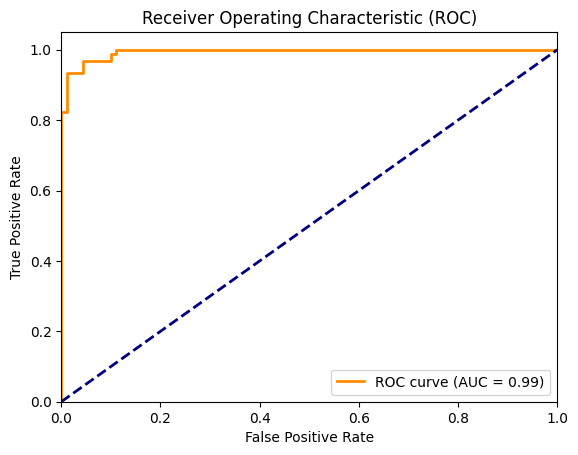

In [ ]:
fpr, tpr, thresholds = roc_curve(test_generator.classes, test_preds_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


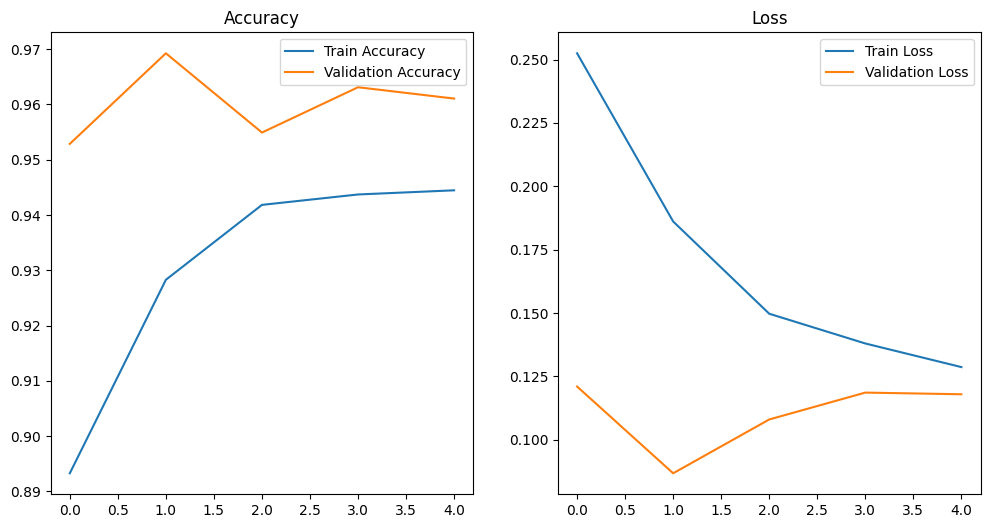

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
model.save('/content/model/dead_chicken.h5')

In [ ]:
def upload_and_predict(model):
    uploaded = files.upload()

    for fn in uploaded.keys():
        img_path = io.BytesIO(uploaded[fn])
        img = image.load_img(img_path, target_size=(224, 224))

        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)

        if prediction[0] > 0.6:
            print("Prediksi: Dead")
        else:
            print("Prediksi: Alive")


Saving large-poultry_chicken_day_old_chicks.webp to large-poultry_chicken_day_old_chicks.webp
Saving Daging_Ayam_Titipku.jpg to Daging_Ayam_Titipku.jpg
Saving 01h7pc0q6g9mheak8h0cf0srm8.jpg to 01h7pc0q6g9mheak8h0cf0srm8.jpg
Saving 057463300_1572940011-shutterstock_127677473.webp to 057463300_1572940011-shutterstock_127677473.webp
Saving Puluhan-Unggas-Milik-Warga-Mati-Mendadak-590x330.jpg to Puluhan-Unggas-Milik-Warga-Mati-Mendadak-590x330 (1).jpg
Saving ayam-mati-mendadak-apa-flu-burung-300x225.webp to ayam-mati-mendadak-apa-flu-burung-300x225.webp
Saving broiler.jpeg to broiler.jpeg
Saving images (1).jpeg to images (1).jpeg
Saving Ayam Mati.jpg to Ayam Mati.jpg
Saving images.jpeg to images.jpeg
Saving deadchicken_blog_UK-1024x0-c-default.jpg to deadchicken_blog_UK-1024x0-c-default.jpg


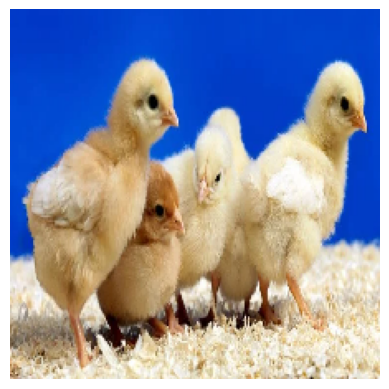

1/1 [==============================] - 1s 697ms/step
Prediksi: Alive


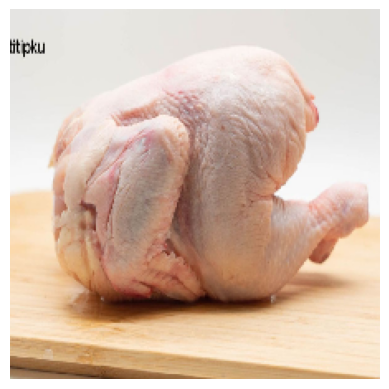

1/1 [==============================] - 0s 47ms/step
Prediksi: Alive


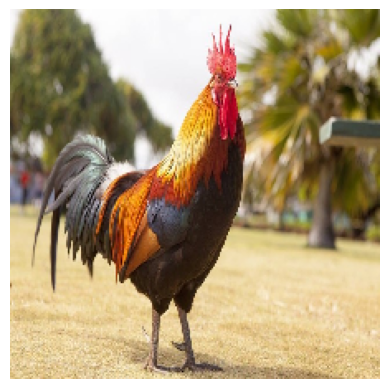

1/1 [==============================] - 0s 47ms/step
Prediksi: Alive


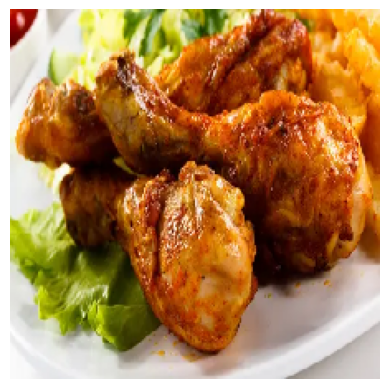

1/1 [==============================] - 0s 49ms/step
Prediksi: Alive


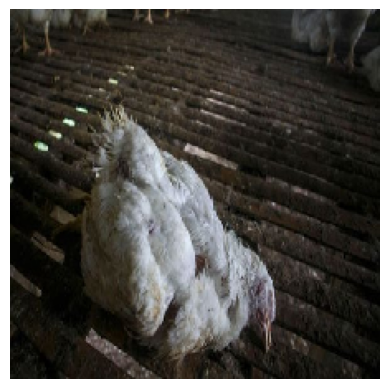

1/1 [==============================] - 0s 50ms/step
Prediksi: Dead


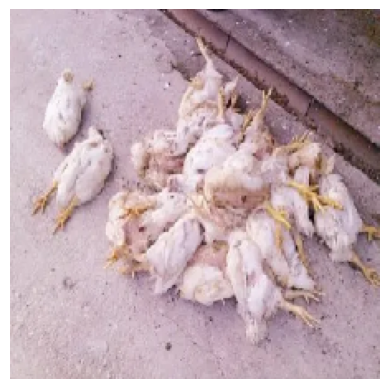

1/1 [==============================] - 0s 54ms/step
Prediksi: Alive


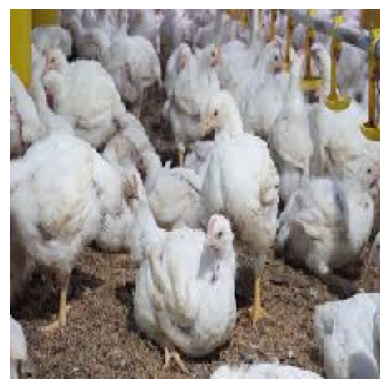

1/1 [==============================] - 0s 44ms/step
Prediksi: Alive


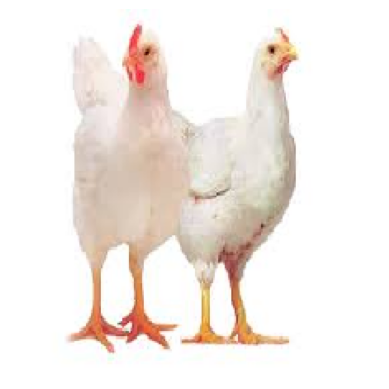

1/1 [==============================] - 0s 61ms/step
Prediksi: Alive


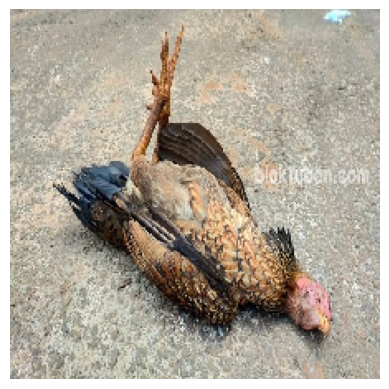

1/1 [==============================] - 0s 44ms/step
Prediksi: Dead


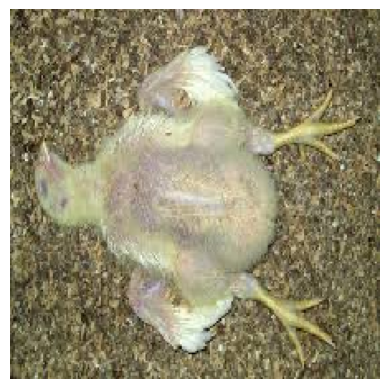

1/1 [==============================] - 0s 46ms/step
Prediksi: Dead


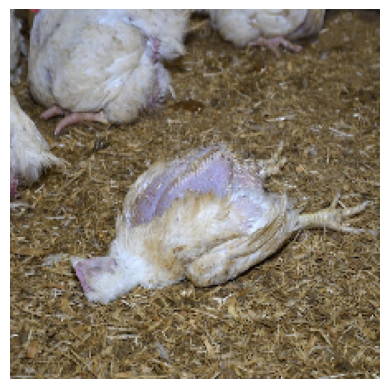

1/1 [==============================] - 0s 46ms/step
Prediksi: Dead


In [ ]:
model = load_model('/content/dead_chicken.h5')

upload_and_predict(model)